# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

import seaborn as sns

#Additional imports
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,recall_score, precision_score, f1_score, plot_confusion_matrix, balanced_accuracy_score, plot_precision_recall_curve, plot_roc_curve, precision_recall_curve
from sklearn.decomposition import PCA

%matplotlib inline


# API for students

In [2]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

import class_helper
%aimport class_helper

clh= class_helper.Classification_Helper()

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [3]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [4]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

## Clean the Data 

In [6]:
#From the observation above, we will convert all the object dtypes to float dtypes
#We will also replace any non numeric entries with NaN

#Create function which calls each column that has object dtypes and change them to  
def Numerictransform(df):
    cols = df.columns[df.dtypes.eq('object')] #selects all columns with objects dtypes
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    #df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

df = Numerictransform(data)
df.head() 
df.info()


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.417690,0.05680,1.1605,-126.390,0.413550,0.025417,1.23950,1.16500,0.51773,...,0.049094,0.85835,0.123220,5.6167,7.4042,164.310,2.2214,1.3340,0,4510
1,-0.023834,0.210100,0.50839,4.2374,22.034,0.058412,-0.027621,3.65790,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.8020,6.4782,0,3537
2,0.030515,0.446060,0.19569,1.5650,35.766,0.281960,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.252660,15.0490,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.6800,438.200,0.136490,0.058164,10.85300,1.02790,0.61173,...,0.085524,0.97282,0.000000,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.497120,0.12316,1.3036,-71.398,0.000000,0.001007,1.01160,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.5820,114.580,3.1854,2.7420,0,1529


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4816 non-null   float64
 1   X2        4816 non-null   float64
 2   X3        4816 non-null   float64
 3   X4        4803 non-null   float64
 4   X5        4808 non-null   float64
 5   X6        4816 non-null   float64
 6   X7        4816 non-null   float64
 7   X8        4804 non-null   float64
 8   X9        4818 non-null   float64
 9   X10       4816 non-null   float64
 10  X11       4816 non-null   float64
 11  X12       4803 non-null   float64
 12  X13       4818 non-null   float64
 13  X14       4816 non-null   float64
 14  X15       4812 non-null   float64
 15  X16       4804 non-null   float64
 16  X17       4804 non-null   float64
 17  X18       4816 non-null   float64
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4744 non-null   floa

There are 4818 companies.
- After transforming data, we can see that there is some missings data points
- There are some columns with large data missing: X37, X27, X45, X60


Most notably, feature X37 ((current assets - inventories) / long-term liabilities) is missing over 2000 values. This is probably because some companies don't have long-term liabilites, making the input undefined.

## Create test set 

Since this data set is technically a training set for the withheld data it will be used to train the model in the end.

For the time being it will be used as training and test sets in order to measure model performance through the iterations in the following steps.

In [7]:
#create feature subset(attributes X1 thru X64) and target subset(Bankruptcy indicator)
y = df["Bankrupt"]
X = df.drop(columns=["Bankrupt", "Id"])

X_train = None
X_test = None
y_train = None
y_test = None

# Split data into train and test
# Create variables X_train, X_test, y_train, y_test
#   X_train: training examples
#   y_train: Bankruptcy labels of the training examples
#   X_test:  test examples
#   y_test:  Bankruptcy labels of test examples

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=47)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (4336, 64)
X_test shape:  (482, 64)
y_train shape:  (4336,)
y_test shape:  (482,)


# Exploratory Data Analysis

In [8]:
train_data = pd.concat([X_train, y_train], axis=1, join="inner")

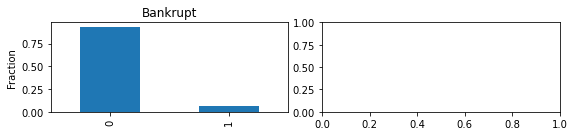

In [9]:
clh.plot_attrs(train_data, ["Bankrupt"], attr_type="Cat", plot=True, normalize=True)


Theres a clear imbalance in the data.  This can be solved simply by choosing a model that is not senstivie to imbalance.  Such as Decision Trees.

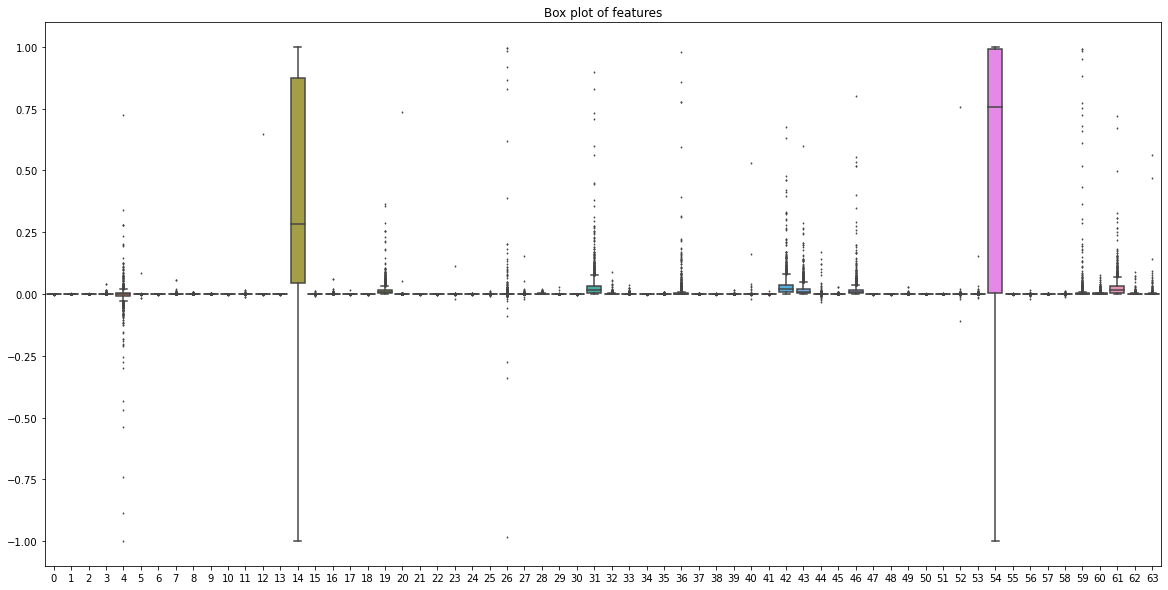

In [10]:
_ = plt.figure(figsize=(20,10))
_ = sns.boxplot(data = preprocessing.normalize(X.dropna()), orient="v", fliersize=1)
_ = plt.title("Box plot of features")

Most features have small standard deviations.
- Some may have outliers

In [11]:
train_bankrupt = train_data.loc[train_data['Bankrupt'] == 1]
train_survived = train_data.loc[train_data['Bankrupt'] == 0]

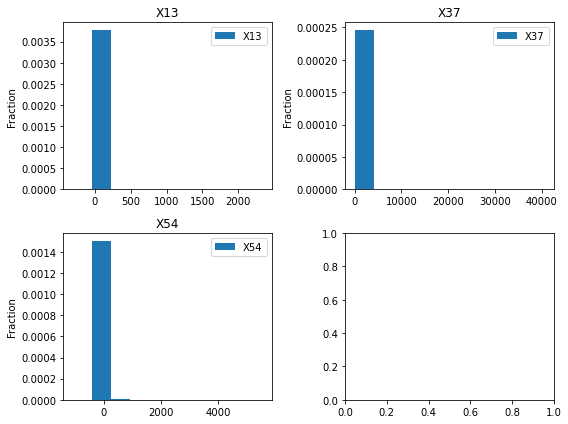

In [12]:
clh.plot_attrs(train_survived, ["X13","X37","X54"], attr_type="Num", normalize=True)

In [13]:
train_data["X37"].describe()

count     2469.000000
mean       104.283539
std       1253.266086
min         -4.325800
25%          1.288700
50%          3.687100
75%         15.266000
max      40559.000000
Name: X37, dtype: float64

In [14]:
train_bankrupt["X37"].describe()
train_survived["X37"].describe()

count     128.000000
mean       30.336652
std       139.163699
min         0.060415
25%         1.037450
50%         2.633150
75%         8.705125
max      1212.000000
Name: X37, dtype: float64

count     2341.000000
mean       108.326770
std       1286.556116
min         -4.325800
25%          1.303400
50%          3.757100
75%         15.778000
max      40559.000000
Name: X37, dtype: float64

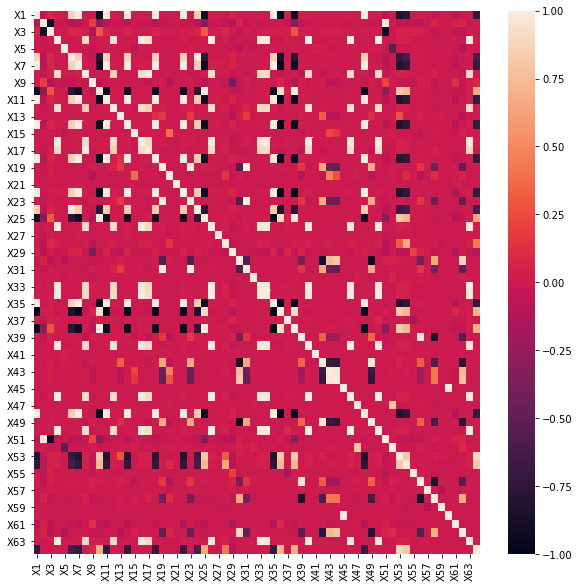

In [15]:
# Heatmap of linear correlation between feature
_ = plt.figure(figsize=(10,10))
_ = sns.heatmap(X.corr(), vmin=-1, vmax=1)

There are some highly correlated features, but majority have no linear correlation

# Prepare Data and Transformations

## Clean Data

After seeing Feature X37 does not have a significant amount of values, it will be dropped from the training set

In [16]:
#Create new training and test sets from original dataframe 
y = df["Bankrupt"]
X = df.drop(columns=["X37", "Bankrupt","Id"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=47)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (4336, 63)
X_test shape:  (482, 63)
y_train shape:  (4336,)
y_test shape:  (482,)


## Transformation Objects

The remainder of the features with missing values will be simply imputed with the mean.

In [17]:
## Create Scaler and Imputer Object
scaler = None
imputer = None

scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

# Training and Testing Models

## Baseline Model

The above Transformers will be used in a pipeline and will fit the following Classification models: 
- Logistic Regression
- Support Vector Classifier (SVC)
- Random Forest Calssifier  

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#Creating model objects
logistic_clf = LogisticRegression(solver='liblinear')

svc_clf = SVC(gamma="auto")

RF_clf = RandomForestClassifier(n_estimators=100, random_state=35)


The below For Loop will both fit the models using cross-validation and produce both the in and out of sample scores for each model.

In [19]:
for name, clf in { "Logistic Regression": logistic_clf,
                   "SVC": svc_clf,
                   "Random Forest": RF_clf
                 }.items():
    
    # Combine the transformation pipeline with a final classification step
    model_pipeline = Pipeline(steps=[ ("imputer", imputer),
                                      ("Standardscaler", scaler),
                                      ("classify", clf)
                                    ]
                             )
    
    _= model_pipeline.fit(X_train, y_train)
    
    # Cross validation on the pipeline
    scores = cross_val_score(model_pipeline, X_train, y_train, cv=10)
    
    # Out of Sample accuracy scores
    y_test_pred = model_pipeline.predict(X_test)
    score_out_of_sample = accuracy_score(y_test, y_test_pred)
    
    print("Model: {m:s} avg cross validation score={s:3.4f}\n".format(m=name, s=scores.mean()))
    print("       {m:s} out-of-sample score={s:3.4f}\n".format(m=name, s=score_out_of_sample))

Model: Logistic Regression avg cross validation score=0.9336

       Logistic Regression out-of-sample score=0.9295

Model: SVC avg cross validation score=0.9359

       SVC out-of-sample score=0.9336

Model: Random Forest avg cross validation score=0.9506

       Random Forest out-of-sample score=0.9440



It can be seen from the scores above that the Random Forect Classifier provides the best scores both in and out of sample.    

We will analyze this model and see if we can further improve the scores.

## Evaluate Baseline Model

### Selecting Random Forest and Performance Summary

y actual : 
0    449
1     33
Name: Bankrupt, dtype: int64
y predicted : 
0    474
1      8
dtype: int64


Accuracy Score : 0.9439834024896265
Class balanced Accuracy=0.605
Precision Score : 0.875
Recall Score : 0.21212121212121213


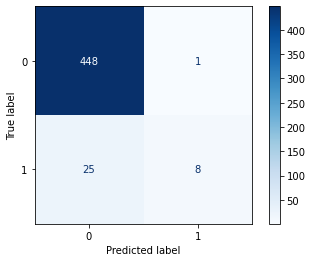

In [20]:
RF_clf = RandomForestClassifier(n_estimators=100, random_state=75)
name = "Random Forest Classifier"

model_pipeline = Pipeline(steps=[ ("imputer", imputer),
                                  ("Standardscaler", scaler),
                                  ("classify", RF_clf)
                                    ]
                             )
pipeline_fit= model_pipeline.fit(X_train, y_train)

#Visualize test set and the predicted values from the model
print('y actual : \n' +  str(pd.Series(y_test).value_counts()))
print('y predicted : \n' + str(pd.Series(y_test_pred).value_counts()))

#put visualization into a confusion matrix
plot_confusion_matrix(model_pipeline,X_test,y_test, cmap=plt.cm.Blues)

#printing accuracy score, balanced accuracy score, precision score, and recall score for the out of sample LogisticRegression(solver="liblinear") model
print('Accuracy Score : ' + str(accuracy_score(y_test,y_test_pred)))
print("Class balanced Accuracy={a:3.3f}".format(a=balanced_accuracy_score(y_test,  y_test_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_test_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_test_pred)))

From the above scores it can be seen that the Random Forest model failed to predict 25 bankruptcies while only truly predicting 8 bankruptcies.  Resulting in a fairly poor Recall score of 0.21.    

Since it is far worse to fail to predict bankruptcies (by a magnitude of 5 times), we must further improve the model's Recall Score.

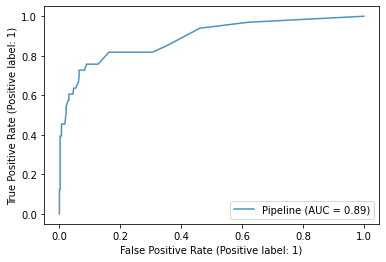

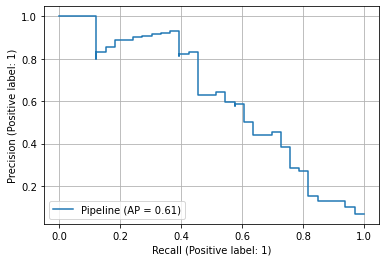

In [23]:
# ROC Curve and precision recall curve
rfc_disp = plot_roc_curve(pipeline_fit, X_test, y_test, alpha=0.8)
plt.show()
disp = plot_precision_recall_curve(pipeline_fit, X_test, y_test)
plt.grid()

- The ROC Curve is bowing towards the top left, but could be a little better.
- The Precision Recall curve is also trending in the right direction but can become slightly better.

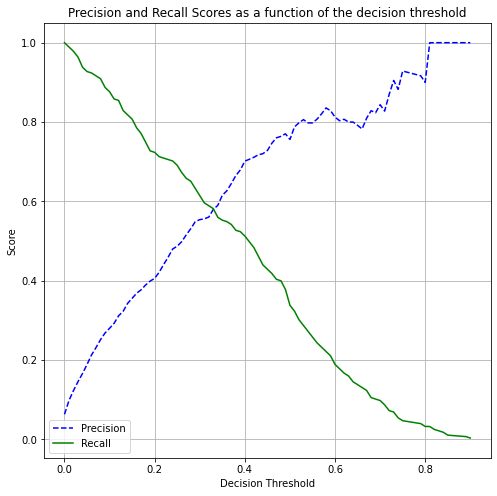

In [24]:
# Plot precision, recall trade-off
y_scores = cross_val_predict(model_pipeline, X_train, y_train, cv=10, method='predict_proba')[:,1]
p, r, thresholds = precision_recall_curve(y_train, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
plot_precision_recall_vs_threshold(p, r, thresholds)
plt.grid()

From the curve above, there will be great tradeoff between the Recall and Precision of the model

## Resampling to correct imbalanced data 

### SMOTE+ENN 

Next the training data will be resampled by SMOTE+ENN to balance the data
- This will result in a decrease in precision, but will hopefully bring up the recall

In [30]:
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline, Pipeline

def RFClf(X_train, y_train, X_test, y_test):
    """
    Create Random forest model that returns in and out of sample scores (via cross validation), accuracy score, precision score and recall score.
    Also returns confusion matrix.
    --------
    Parameters  
    X_train: DataFrame
    -training feature set
    
    y_train:DataFrame
    -traing target values
    
    X_test: DataFrame
    -test feature set
    
    y_test: DataFrame
    -test target set
    
    """
    RF_clf = RandomForestClassifier(n_estimators=100, random_state=75)
    name = "Random Forest Classifier"
    
    #Class to perform over-sampling using SMOTE and cleaning using ENN.
    sme = SMOTEENN(random_state=42)

    model_pipeline = Pipeline(steps=[ ("imputer", imputer),
                                      ("Standardscaler", scaler),
                                      ("SMOTE + ENN", sme),
                                      ("classify", RF_clf)
                                    ]
                             )
    
    _= model_pipeline.fit(X_train, y_train)
    
    
    # Cross validation on the pipeline
    scores = cross_val_score(model_pipeline, X_train, y_train, cv=10)
    
    # Out of Sample accuracy scores
    y_test_pred = model_pipeline.predict(X_test)
    score_out_of_sample = accuracy_score(y_test, y_test_pred)
    
    print("Model: {m:s} avg cross validation score={s:3.4f}\n".format(m=name, s=scores.mean()))
    print("       {m:s} out-of-sample score={s:3.4f}\n".format(m=name, s=score_out_of_sample))
    
    #Visualize test set and the predicted values from the model
    print('y actual : \n' +  str(pd.Series(y_test).value_counts()))
    print('y predicted : \n' + str(pd.Series(y_test_pred).value_counts()))

    #put visualization into a confusion matrix
    plot_confusion_matrix(model_pipeline,X_test,y_test, cmap=plt.cm.Blues)

    #printing accuracy score, precision score, recall score, and F1 score for the out of sample LogisticRegression(solver="liblinear") model
    print('Accuracy Score : ' + str(accuracy_score(y_test,y_test_pred)))
    print("Class Balanced Accuracy : {a:3.3f}".format(a=balanced_accuracy_score(y_test,  y_test_pred)))
    print('Precision Score : ' + str(precision_score(y_test,y_test_pred)))
    print('Recall Score : ' + str(recall_score(y_test,y_test_pred)))



Model: Random Forest Classifier avg cross validation score=0.8978

       Random Forest Classifier out-of-sample score=0.9004

y actual : 
0    449
1     33
Name: Bankrupt, dtype: int64
y predicted : 
0    431
1     51
dtype: int64
Accuracy Score : 0.9004149377593361
Class Balanced Accuracy : 0.736
Precision Score : 0.35294117647058826
Recall Score : 0.5454545454545454


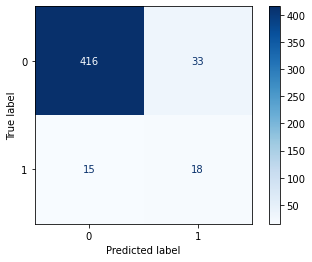

In [27]:
RFClf(X_train, y_train, X_test, y_test)

With resampling the data we see a great improvement in the recall score at the expense of the precision score.  

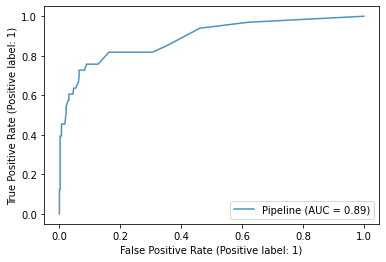

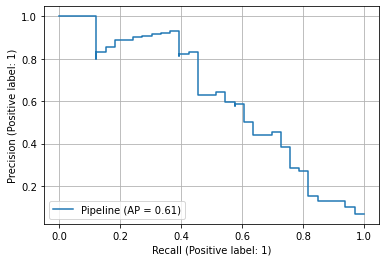

In [28]:
rfc_disp = plot_roc_curve(pipeline_fit, X_test, y_test, alpha=0.8)
plt.show()
disp = plot_precision_recall_curve(pipeline_fit, X_test, y_test)
plt.grid()

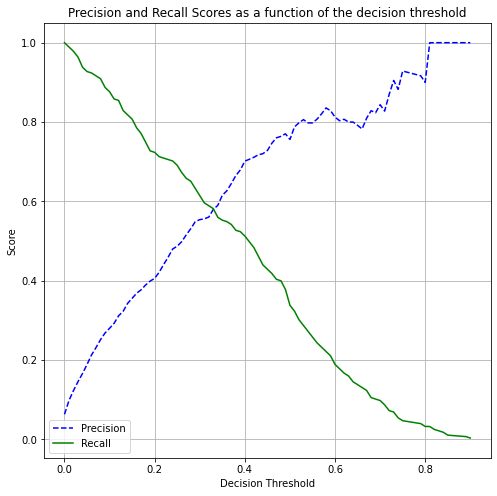

In [29]:
# Plot precision, recall trade-off
y_scores = cross_val_predict(model_pipeline, X_train, y_train, cv=10, method='predict_proba')[:,1]
p, r, thresholds = precision_recall_curve(y_train, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
plot_precision_recall_vs_threshold(p, r, thresholds)
plt.grid()

### SMOTE+Tomek

In [31]:
def RFClf2(X_train, y_train, X_test, y_test):
    """
    Create Random forest model that returns in and out of sample scores (via cross validation), accuracy score, precision score and recall score.
    Also returns confusion matrix.
    --------
    Parameters  
    X_train: DataFrame
    -training feature set
    
    y_train:DataFrame
    -traing target values
    
    X_test: DataFrame
    -test feature set
    
    y_test: DataFrame
    -test target set
    
    """
    RF_clf = RandomForestClassifier(n_estimators=100, random_state=75)
    name = "Random Forest Classifier"
    
    #Class to perform over-sampling using SMOTE and cleaning using ENN.
    smt = SMOTETomek(random_state=43)

    model_pipeline = Pipeline(steps=[ ("imputer", imputer),
                                      ("Standardscaler", scaler),
                                      ("SMOTE + Tomek", smt),
                                      ("classify", RF_clf)
                                    ]
                             )
    
    _= model_pipeline.fit(X_train, y_train)
    
    
    # Cross validation on the pipeline
    scores = cross_val_score(model_pipeline, X_train, y_train, cv=10)
    
    # Out of Sample accuracy scores
    y_test_pred = model_pipeline.predict(X_test)
    score_out_of_sample = accuracy_score(y_test, y_test_pred)
    
    print("Model: {m:s} avg cross validation score={s:3.4f}\n".format(m=name, s=scores.mean()))
    print("       {m:s} out-of-sample score={s:3.4f}\n".format(m=name, s=score_out_of_sample))
    
    #Visualize test set and the predicted values from the model
    print('y actual : \n' +  str(pd.Series(y_test).value_counts()))
    print('y predicted : \n' + str(pd.Series(y_test_pred).value_counts()))

    #put visualization into a confusion matrix
    plot_confusion_matrix(model_pipeline,X_test,y_test, cmap=plt.cm.Blues)

    #printing accuracy score, precision score, recall score, and F1 score for the out of sample LogisticRegression(solver="liblinear") model
    print('Accuracy Score : ' + str(accuracy_score(y_test,y_test_pred)))
    print("Class Balanced Accuracy : {a:3.3f}".format(a=balanced_accuracy_score(y_test,  y_test_pred)))
    print('Precision Score : ' + str(precision_score(y_test,y_test_pred)))
    print('Recall Score : ' + str(recall_score(y_test,y_test_pred)))



Model: Random Forest Classifier avg cross validation score=0.9417

       Random Forest Classifier out-of-sample score=0.9502

y actual : 
0    449
1     33
Name: Bankrupt, dtype: int64
y predicted : 
0    459
1     23
dtype: int64
Accuracy Score : 0.950207468879668
Class Balanced Accuracy : 0.735
Precision Score : 0.6956521739130435
Recall Score : 0.48484848484848486


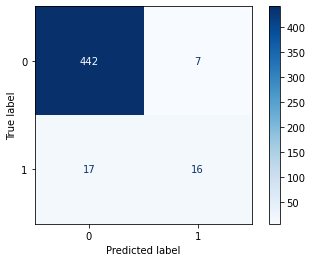

In [32]:
RFClf2(X_train, y_train, X_test, y_test)

In Conclusion:
- both improve the recall score
- SMOKE+ENN increases recall more than SMOKE+Tomek, but also suffers more with precision
- SMOKE+Tomek surprisingly increases in precision as well, but still needs a higher score in recall

# PCA Fine Tuning

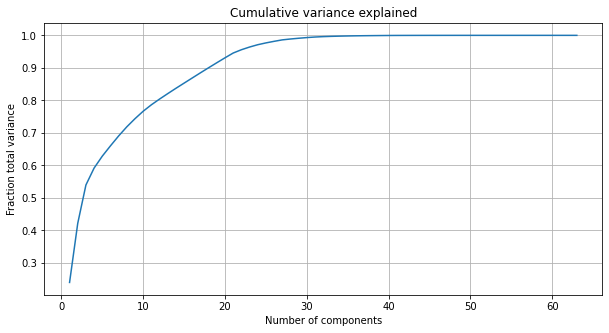

In [33]:
# Using PCA to reduce dimension of features
transform_pipeline = Pipeline(steps= [("imputer", imputer),
                                      ("Standardscaler", scaler),
                                     ]
                             )

pca = PCA()
X_transformed = transform_pipeline.fit_transform(X_train)
_ = pca.fit(X_transformed)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
_ = plt.figure(figsize=(10,5))
_ = plt.plot(
    range(1, exp_var_cumul.shape[0] + 1),
    exp_var_cumul
)
_ = plt.title("Cumulative variance explained")
_ = plt.xlabel("Number of components")
_ = plt.ylabel("Fraction total variance")
plt.grid()

In [49]:
# Reduce dimension
pca = PCA(n_components=35)
sme = SMOTEENN(random_state=42)
smt = SMOTETomek(random_state=43)
pca_pipeline = Pipeline(steps=[ ("imputer", imputer),
                                      ("Standardscaler", scaler),
                                      ("SMOTE + Tomek", smt),
                                      ("PCA", pca),
                                      ("classify", RF_clf)
                                    ]
                             )

# Adjust threshold
threshold = 0.15
predicted_proba = cross_val_predict(pca_pipeline, X_train, y_train, cv=10, method='predict_proba')
y_pred = (predicted_proba [:,1] >= threshold).astype('int')

    
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred)))
print("Class Balanced Accuracy : {a:3.3f}".format(a=balanced_accuracy_score(y_train,  y_pred)))
print('Precision Score : ' + str(precision_score(y_train,y_pred)))
print('Recall Score : ' + str(recall_score(y_train,y_pred)))

Accuracy Score : 0.6674354243542435
Class Balanced Accuracy : 0.777
Precision Score : 0.14912808177991582
Recall Score : 0.9018181818181819


PCA didn't have much impact

In [54]:
for threshold in np.linspace(0.1, 0.3, 3):
    print("Result with threshold=", threshold)
    predicted_proba = cross_val_predict(model_pipeline, X_train, y_train, cv=10, method='predict_proba')
    y_pred = (predicted_proba [:,1] >= threshold).astype('int')
    
    accuracy = accuracy_score(y_train, y_pred)
    
    print("Accuracy Score={a:3.4f}".format(a=accuracy))
    print("Precision Score={p:3.4f}".format(p=precision_score(y_train, y_pred)))
    print("Recall Score={r:3.4f}".format(r=recall_score(y_train, y_pred)))
    print("-------")

Result with threshold= 0.1
Accuracy Score=0.8494
Precision Score=0.2802
Recall Score=0.8764
-------
Result with threshold= 0.2
Accuracy Score=0.9154
Precision Score=0.4061
Recall Score=0.7236
-------
Result with threshold= 0.3
Accuracy Score=0.9442
Precision Score=0.5541
Recall Score=0.6145
-------


Since the goal is to avoid failing to identify a company that will go bankrupt, the model chosen will need a high recall score.  From the available options in the threshold training, the model will use a 0.1 threshold.

# Create final training set including all sample

In [55]:
y = df["Bankrupt"]
X = df.drop(columns=["Bankrupt", "Id","X37"])

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [53]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)


Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

# Submission

In [56]:
import pandas as pd
import os

def MyModel(X_dataframe):
    # It should create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # YOUR CODE GOES HERE
    df_input = Numerictransform(X_dataframe) #change input DF into numeric type
    df_clean = df_input.drop(columns=["Id","X37"])  #Drop ID and X37 feature due to lack of data
    
    scaler = StandardScaler()
    imputer = SimpleImputer(strategy='mean')

    RF_clf = RandomForestClassifier(n_estimators=100, random_state=75)
    name = "Random Forest Classifier"
    
    #Class to perform over-sampling using SMOTE and cleaning using Tomek
    smt = SMOTETomek(random_state=43)
    
    #model pipeline with transformations, SMOTE+ENN, and RandomForest Classifier
    model_pipeline = Pipeline(steps=[ ("imputer", imputer),
                                      ("Standardscaler", scaler),
                                      ("SMOTE + Tomek", smt),
                                      ("classify", RF_clf)
                                    ]
                             )
    
    _ = model_pipeline.fit(X,y)
    
    #Set up threshold
    threshold = 0.1
    
    #Predict away
    predicted_proba = model_pipeline.predict_proba(df_clean)
    predictions = (predicted_proba [:,1] >= threshold).astype('int')
    
    return predictions

In [57]:
MyModel(holdout_data)

array([0, 1, 1, ..., 1, 0, 0])



# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

The following cell
- Assumes that you have created `X_test, y_test` as your proxy for an out of sample dataset
    - It serves the same function as `X_hold`, the holdout dataset, but you have the associated target (only the instructors have `y_hold`)

In [ ]:
# Give the model a name (will appear in the print statement)
name = "Abruzzo's Random Forest"

y_test_pred = MyModel()

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )